In [1]:
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt

In [2]:
from onsager import crystal, cluster, supercell
from SymmLayers import GConv, GAvg, R3ConvSites, R3Conv

# Load Crystal data

In [6]:
# Read crystal data
CrysDatPath = "../CrysDat_BCC/"

# Load the test batch of random states related to each other by symmetry
TestStates = np.load(CrysDatPath + "TestStates.npy")

# Load symmetry operations with which they were constructed
with open(CrysDatPath + "GroupOpsIndices.pkl", "rb") as fl:
    GIndtoGDict = pickle.load(fl)

dxNN = np.load(CrysDatPath + "nnJumpLatVecs.npy")
RtoSiteInd = np.load(CrysDatPath + "RtoSiteInd.npy")
SiteIndtoR = np.load(CrysDatPath + "SiteIndtoR.npy")
GpermNNIdx = np.load(CrysDatPath + "GroupNNpermutations.npy")
siteShellIndices = np.load(CrysDatPath + "SitesToShells.npy")

NNsiteList = np.load(CrysDatPath + "NNsites_sitewise.npy")
N_ngb = NNsiteList.shape[0]
Nsites = NNsiteList.shape[1]

with open(CrysDatPath + "supercellBCC.pkl", "rb") as fl:
    superBCC = pickle.load(fl)

In [7]:
N_ngb, Nsites

(9, 512)

In [8]:
N_units = 8

## Next we make symmetry parameters

In [9]:
GnnPerms = pt.tensor(GpermNNIdx).long()
NNsites = pt.tensor(NNsiteList).long()
SitesToShells = pt.tensor(siteShellIndices).long()

Ng = GnnPerms.shape[0]
Ndim = 3
gdiags = pt.zeros(Ng*Ndim, Ng*Ndim).double()
for gInd, g in GIndtoGDict.items():
    rowStart = gInd * Ndim
    rowEnd = (gInd + 1) * Ndim
    gdiags[rowStart : rowEnd, rowStart : rowEnd] = pt.tensor(g.cartrot)

# Now let's build the network

In [10]:
# for now, let's make an 8-channel, 4-layer network
class GCNet(nn.Module):
    def __init__(self, GnnPerms, NNsites, SitesToShells,
                dim=3, N_ngb=N_ngb, mean=0., std=0.1):
        
        super().__init__()
        
        self.net = nn.Sequential(
            GConv(1, 8, GnnPerms, NNsites, N_ngb, mean=mean, std=std),
            nn.Softplus(),
            GAvg(),
            
            GConv(8, 8, GnnPerms, NNsites, N_ngb, mean=mean, std=std),
            nn.Softplus(),
            GAvg(),

            GConv(8, 8, GnnPerms, NNsites, N_ngb, mean=mean, std=std),
            nn.Softplus(),
            GAvg(),

            GConv(8, 8, GnnPerms, NNsites, N_ngb, mean=mean, std=std),
            nn.Softplus(),
            GAvg(),

            # The last GConv layer must have a single out channel
            GConv(8, 1, GnnPerms, NNsites, N_ngb, mean=mean, std=std),
            nn.Softplus(),
            GAvg(),

            R3ConvSites(SitesToShells, GnnPerms, gdiags, NNsites, N_ngb,
                   dim, mean=mean, std=std*10)        
        )
    
    def forward(self, InState):
        y = self.net(InState)
        return y

In [11]:
gNet = GCNet(GnnPerms.long(), NNsites, SitesToShells,
                dim=3, N_ngb=N_ngb, mean=0.05, std=0.01).double()

## Now Pass the Input states and get the output

In [12]:
Nbatch = TestStates.shape[0]
StateTensors = pt.tensor(TestStates/2.0).double().view(Nbatch, 1, TestStates.shape[1])
StateTensors.shape

torch.Size([48, 1, 512])

In [13]:
y=gNet(StateTensors)

In [14]:
y_np = y.data.numpy().copy()

In [15]:
print(np.min(y_np), np.max(y_np))

-0.2987601372278587 0.2987601372278584


(array([ 6., 14., 20., 40., 36., 59., 66., 55., 37., 45., 30., 34., 21.,
         8., 15., 12.,  3.,  6.,  3.,  2.]),
 array([0.01758085, 0.0332688 , 0.04895675, 0.06464469, 0.08033264,
        0.09602059, 0.11170854, 0.12739649, 0.14308443, 0.15877238,
        0.17446033, 0.19014828, 0.20583623, 0.22152417, 0.23721212,
        0.25290007, 0.26858802, 0.28427597, 0.29996391, 0.31565186,
        0.33133981]),
 <BarContainer object of 20 artists>)

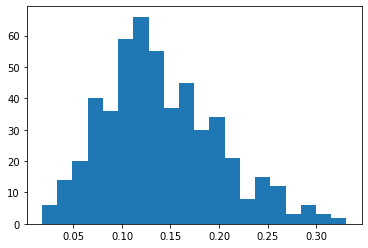

In [16]:
# Check that y vectors are not too small so as to have meaningful tests
plt.hist(np.linalg.norm(y_np[0], axis=0), bins=20)

In [17]:
# Check that subsequent y vectors are related by symmetry
y0 = y_np[0].copy()
for gInd, g in GIndtoGDict.items():
    for site in range(512):
        Rsite = SiteIndtoR[site]
        RsiteNew, _ = superBCC.crys.g_pos(g, Rsite, (0, 0))
        RsiteNew = RsiteNew % 8 # bring back into supercell
        siteNew = RtoSiteInd[RsiteNew[0], RsiteNew[1], RsiteNew[2]]
        assert np.allclose(np.dot(g.cartrot, y0[:, site]), y_np[gInd, :, siteNew])
        
print("Vector Layer Symmetry assertions passed")

Vector Layer Symmetry assertions passed


In [18]:
def checkSymLayer(out, Nch):
    for ch in range(Nch):
        outsamp0 = out[0, ch, :]
        for gInd, g in GIndtoGDict.items():
            outsamp = pt.zeros_like(outsamp0)
            for siteInd in range(512):
                RSite = SiteIndtoR[siteInd]
                Rnew, _ = superBCC.crys.g_pos(g, RSite, (0,0))
                Rnew %= 8
                siteIndNew = RtoSiteInd[Rnew[0], Rnew[1], Rnew[2]]
                outsamp[siteIndNew] = outsamp0[siteInd]
            assert pt.allclose(outsamp, out[gInd, ch, :], atol=1e-12)

In [19]:
# Check symmetries of internal layers:
out = pt.clone(StateTensors)
for l in range(0, len(gNet.net)-1, 3):
    assert out.shape[1]==gNet.net[l].Psi.shape[1]
    out = gNet.net[l].forward(out)
    out = gNet.net[l+1].forward(out)
    out = gNet.net[l+2].forward(out)
    Nch = out.shape[1]
    assert Nch==gNet.net[l].Psi.shape[0]
    checkSymLayer(out, Nch)
    print("Layer {} symmetry assertion passed".format((l + 3)//3))

Layer 1 symmetry assertion passed
Layer 2 symmetry assertion passed
Layer 3 symmetry assertion passed
Layer 4 symmetry assertion passed
Layer 5 symmetry assertion passed


In [20]:
out.shape

torch.Size([48, 1, 512])

In [30]:
# Check site-weighted vector sum
from SymmLayers import R3Conv
C3Conv = R3Conv(SitesToShells, GnnPerms.long(), gdiags, NNsites, N_ngb,
                   dim=3, mean=0.0, std=1.).double()

y = C3Conv(out).detach().numpy()
y[1]

array([-0.00020615,  0.0036139 , -0.00029587])

In [31]:
for gInd, g in GIndtoGDict.items():
    assert np.allclose(np.dot(g.cartrot, y[0]), y[gInd])
print("Weighted sum of vector tests passed")

Weighted sum of vector tests passed


In [32]:
# Do the vector test
with pt.no_grad():
    out = pt.clone(StateTensors)
    y=gNet(StateTensors).detach().numpy()
    
    for l in range(0, len(gNet.net)-1, 3):
        assert out.shape[1]==gNet.net[l].Psi.shape[1]
        out = gNet.net[l].forward(out)
        out = gNet.net[l+1].forward(out)
        out = gNet.net[l+2].forward(out)
        Nch = out.shape[1]
        assert Nch==gNet.net[l].Psi.shape[0]
            
    Psi = gNet.net[-1].wtVC.T.detach().numpy()
    
    for samp in range(out.shape[0]):
        for site in range(Nsites):
            siteVec = np.zeros(3)
            repSite = out[samp, 0, site].item()
            for ngbInd, ngbSite in enumerate(NNsiteList[:, site]):
                # check that only differences are necessary for cubic systems
                rep = out[samp, 0, ngbSite].item() - repSite
                gvec = np.zeros(3)
                for gInd, g in GIndtoGDict.items():
                    Psi_gInv_ngb = Psi[GpermNNIdx[gInd, ngbInd]]
                    gvec += np.dot(g.cartrot, Psi_gInv_ngb)

                siteVec += rep*gvec/(GnnPerms.shape[0])

            assert np.allclose(siteVec, y[samp, :, site], atol=1e-12)
print("explicit vector conv test done.")

explicit vector conv test done.
